In [12]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii 
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [13]:
df = pd.read_csv('analisis_paquetes.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'analisis_paquetes.csv'

Captura de 10 paquetes

In [14]:
num_of_packets_to_sniff = 10
pcap = sniff(count=num_of_packets_to_sniff)

# rdpcap returns packet list
## packetlist object can be enumerated 
print(type(pcap))
print(len(pcap))
print(pcap)
pcap[0]

<class 'scapy.plist.PacketList'>
10
<Sniffed: TCP:0 UDP:10 ICMP:0 Other:0>


<Ether  dst=74:3a:ef:49:1c:df src=d8:bb:c1:ac:c3:18 type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=76 id=5384 flags= frag=0 ttl=128 proto=udp chksum=0x0 src=192.168.1.27 dst=66.22.222.119 |<UDP  sport=56037 dport=50016 len=56 chksum=0xe29a |<Raw  load='\\xaf\\xcd\x00\x06\x00\x02\\x8d\\xf8\\xfdM\\xa3\x00\\xef\x18\x04o\\x8aY\\x9b\\xfefs\\x81\\xad\\x95\u05ee\\xb3\\xb1\\x83\\xff\\xcd`\\xe8\\xcdQ\\xd8T_\\xd3\\xec\\x82\\xc2\\xed\\x8eH\x00\\x80' |>>>>

In [15]:
ethernet_frame = pcap[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload #recupera la informacion de la capa 4

print("Informacion del frame:")
print(ethernet_frame.summary())

print("Informacion del paquete:")
print(ip_packet.summary())

print("Informacion del segmento:")
print(segment.summary())

print("Data:")
print(data.summary())

ethernet_frame.show()
data.show()

Informacion del frame:
Ether / IP / UDP 192.168.1.27:56037 > 66.22.222.119:50016 / Raw
Informacion del paquete:
IP / UDP 192.168.1.27:56037 > 66.22.222.119:50016 / Raw
Informacion del segmento:
UDP 192.168.1.27:56037 > 66.22.222.119:50016 / Raw
Data:
Raw
###[ Ethernet ]### 
  dst       = 74:3a:ef:49:1c:df
  src       = d8:bb:c1:ac:c3:18
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 76
     id        = 5384
     flags     = 
     frag      = 0
     ttl       = 128
     proto     = udp
     chksum    = 0x0
     src       = 192.168.1.27
     dst       = 66.22.222.119
     \options   \
###[ UDP ]### 
        sport     = 56037
        dport     = 50016
        len       = 56
        chksum    = 0xe29a
###[ Raw ]### 
           load      = '\\xaf\\xcd\x00\x06\x00\x02\\x8d\\xf8\\xfdM\\xa3\x00\\xef\x18\x04o\\x8aY\\x9b\\xfefs\\x81\\xad\\x95\u05ee\\xb3\\xb1\\x83\\xff\\xcd`\\xe8\\xcdQ\\xd8T_\\xd3\\xec\\x82\\xc2\\xed\\x8eH\x00\\x80'

#

In [16]:
print(type(ethernet_frame))
print(type(ip_packet))
print(type(segment))

# Packets can be filtered on layers ie) ethernet_frame[scapy.layers.l2.Ether]
ethernet_type = type(ethernet_frame)
ip_type = type(ip_packet)
tcp_type = type(segment)
print("Ethernet",pcap[ethernet_type])
print("IP", pcap[ip_type])
print("TCP", pcap[tcp_type])

# Scapy provides this via import statements
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP

print("UDP", pcap[UDP])

<class 'scapy.layers.l2.Ether'>
<class 'scapy.layers.inet.IP'>
<class 'scapy.layers.inet.UDP'>
Ethernet <Ether from Sniffed: TCP:0 UDP:10 ICMP:0 Other:0>
IP <IP from Sniffed: TCP:0 UDP:10 ICMP:0 Other:0>
TCP <UDP from Sniffed: TCP:0 UDP:10 ICMP:0 Other:0>
UDP <UDP from Sniffed: TCP:0 UDP:10 ICMP:0 Other:0>


In [17]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(5))

  version ihl tos  len     id flags frag  ttl proto chksum  ... dataofs  \
0       4   5   0   76   5384          0  128    17      0  ...    None   
1       4   5   0   42  47210          0  128    17  49304  ...    None   
2       4   5   0  371   1499    DF    0   50    17  24398  ...    None   
3       4   5   0  168   1500    DF    0   50    17  24600  ...    None   
4       4   5   0  113   1501    DF    0   50    17  24654  ...    None   

  reserved flags  window chksum urgptr options payload  \
0     None  None    None  58010   None    None      48   
1     None  None    None  25649   None    None      18   
2     None  None    None  42181   None    None     343   
3     None  None    None  53432   None    None     140   
4     None  None    None  46112   None    None      85   

                                         payload_raw  \
0  b'\xaf\xcd\x00\x06\x00\x02\x8d\xf8\xfdM\xa3\x0...   
1          b'EPSONP\x00\xff\x00\x00\x00\x00\x00\x00'   
2  b'\x90\xe7\xe4\xc2SU\x1e\xc8\

In [18]:
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,192.168.1.27,66.22.222.119,56037,50016
1,192.168.1.24,255.255.255.255,58632,3289
2,66.22.222.119,192.168.1.27,50016,56037
3,66.22.222.119,192.168.1.27,50016,56037
4,66.22.222.119,192.168.1.27,50016,56037
5,66.22.222.119,192.168.1.27,50016,56037
6,66.22.222.119,192.168.1.27,50016,56037
7,192.168.1.27,66.22.222.119,56037,50016
8,66.22.231.10,192.168.1.27,50001,56038
9,192.168.1.27,66.22.222.119,56037,50016


In [19]:
df.shape

(10, 28)

In [20]:
#save the file analisis_paquetes.pcap in pcap2 and add it to the dataframe
pcap2 = rdpcap('analisis_paquetes.pcap')

for packet in pcap2[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(5))


  version ihl tos  len     id flags frag  ttl proto chksum  ... dataofs  \
0       4   5   0   76   5384          0  128    17      0  ...    None   
1       4   5   0   42  47210          0  128    17  49304  ...    None   
2       4   5   0  371   1499    DF    0   50    17  24398  ...    None   
3       4   5   0  168   1500    DF    0   50    17  24600  ...    None   
4       4   5   0  113   1501    DF    0   50    17  24654  ...    None   

  reserved flags window chksum urgptr options payload  \
0     None  None   None  58010   None    None      48   
1     None  None   None  25649   None    None      18   
2     None  None   None  42181   None    None     343   
3     None  None   None  53432   None    None     140   
4     None  None   None  46112   None    None      85   

                                         payload_raw  \
0  b'\xaf\xcd\x00\x06\x00\x02\x8d\xf8\xfdM\xa3\x0...   
1          b'EPSONP\x00\xff\x00\x00\x00\x00\x00\x00'   
2  b'\x90\xe7\xe4\xc2SU\x1e\xc8\x00\x0

In [21]:
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,192.168.1.27,66.22.222.119,56037,50016
1,192.168.1.24,255.255.255.255,58632,3289
2,66.22.222.119,192.168.1.27,50016,56037
3,66.22.222.119,192.168.1.27,50016,56037
4,66.22.222.119,192.168.1.27,50016,56037
...,...,...,...,...
67,84.54.22.33,10.1.10.53,53,53
68,10.1.10.53,84.54.22.33,53,53
69,84.54.22.33,10.1.10.53,53,53
70,10.1.10.53,84.54.22.33,53,53


In [22]:
df.shape

(72, 28)

#### Estadistica

Muestre cual es la IP origen más frecuente

In [23]:
df['src'].value_counts()


10.1.10.53       31
84.54.22.33      29
66.22.222.119     5
192.168.1.27      3
75.75.75.75       2
192.168.1.24      1
66.22.231.10      1
Name: src, dtype: int64

Muestre cual es la IP destino más frecuente

In [24]:
df['dst'].value_counts()

10.1.10.53         31
84.54.22.33        29
192.168.1.27        6
66.22.222.119       3
75.75.75.75         2
255.255.255.255     1
Name: dst, dtype: int64

¿A qué IPs se comunica la IP del inciso a?

In [25]:
df[df['src'] == '10.1.10.53']['dst'].value_counts()


84.54.22.33    29
75.75.75.75     2
Name: dst, dtype: int64

¿A qué puertos destino se comunica la IP del inciso a?

In [26]:
df[df['src'] == '10.1.10.53']['dport'].value_counts()

53    31
Name: dport, dtype: int64

¿A qué puertos origen se comunica la IP del inciso b?

In [27]:
df[df['src'] == '10.1.10.53']['sport'].value_counts()

53       29
15812     1
23903     1
Name: sport, dtype: int64

Indique el propósito de los puertos que más aparece en los incisos d y e

#### Graficas

In [62]:
payloads_raw = []

Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads enviados de dichas direcciones.

<AxesSubplot:xlabel='src'>

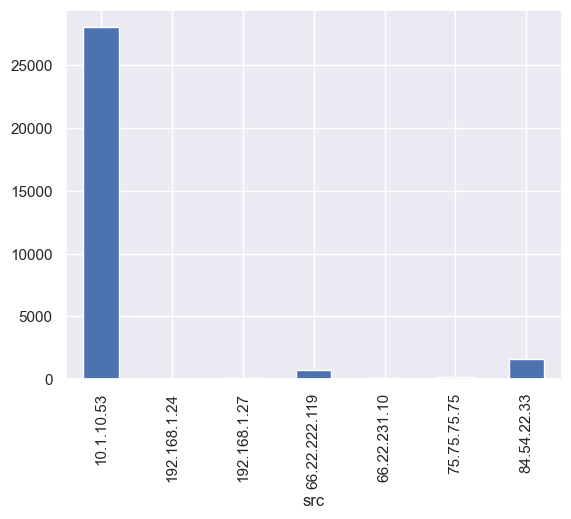

In [189]:
# graph a 2D graph where y axis are IPs org and x axis is the sum of payloads sent to each IP
df.groupby('src')['payload'].sum().plot(kind='bar')

Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads recibidos en dichas direcciones.

<AxesSubplot:xlabel='dst'>

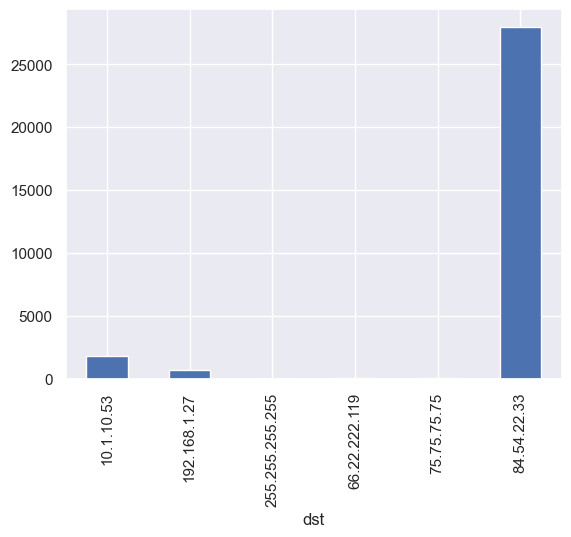

In [159]:
df.groupby('dst')['payload'].sum().plot(kind='bar')

Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los payloads enviados de dichos puertos.

<AxesSubplot:xlabel='sport'>

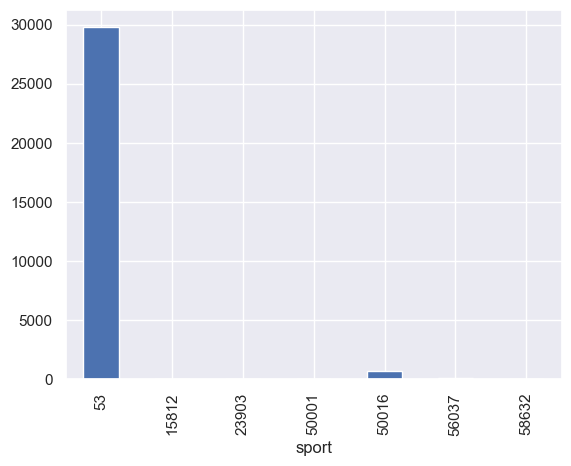

In [160]:
df.groupby('sport')['payload'].sum().plot(kind='bar')

Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los payloads recibidos en dichos puertos

<AxesSubplot:xlabel='dport'>

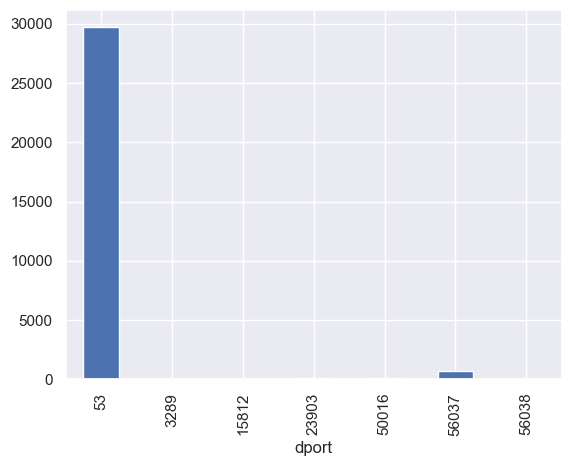

In [161]:
df.groupby('dport')['payload'].sum().plot(kind='bar')

#### Investigación del payload

In [162]:
df2 = df['src'] == '10.1.10.53'
df2 = df[df2]

# reset index
df2 = df2.reset_index()

In [163]:
df2 = df2.drop(columns="index")

In [164]:
# group by payload 
df2.groupby('src')['payload'].sum()

src
10.1.10.53    28053
Name: payload, dtype: object

In [165]:
# Obtenga la IP que más ha intercambiado bytes con la IP más frecuente.

# show 3 dest ips with bigger payload
df.groupby('dst')['payload'].sum().sort_values(ascending=False)

dst
84.54.22.33        27979
10.1.10.53          1790
192.168.1.27         744
66.22.222.119        104
75.75.75.75           74
255.255.255.255       18
Name: payload, dtype: object

In [166]:
# Cree un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa
df3 = df2[df2['dst'] == '84.54.22.33']
df3.head(5)

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
1,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
2,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
3,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
4,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


In [167]:
df.columns

Index(['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto',
       'chksum', 'src', 'dst', 'options', 'time', 'sport', 'dport', 'seq',
       'ack', 'dataofs', 'reserved', 'flags', 'window', 'chksum', 'urgptr',
       'options', 'payload', 'payload_raw', 'payload_hex'],
      dtype='object')

In [212]:
# Obtenga los payloads del DF del inciso 6, y añada cada uno en un array. 
# Muestre el contenido del array.

payloads_raw = df[['dport', 'sport', 'payload_raw']]
payloads_raw = payloads_raw['payload_raw'].tolist()


payloads_string = []

for payload in payloads_raw:
    payloads_string.append(payload.decode('latin-1'))

# ['dport']

# payloads_raw[:2]

In [213]:
payloads_string

['¯Í\x00\x06\x00\x02\x8døýM£\x00ï\x18\x04o\x8aY\x9bþfs\x81\xad\x95×®³±\x83ÿÍ`èÍQØT_Óì\x82Âí\x8eH\x00\x80',
 'EPSONP\x00ÿ\x00\x00\x00\x00\x00\x00',
 '\x90çäÂSU\x1eÈ\x00\x02\x8dö¾Þ\x00\x03\x99LÁ\x96YÐH\x8eK¾\x01ïâ\x81^\x1fÀ\x10\x0bÜ},dÐ\x8bpµ\x03\x02»já¤±¹ìm\x9ay{ôd|>\'ôùý6\x1c£¿gM\x80u}\x80/r¼²Ëú\x82Õ¸\x8b-¡7:\x83\x8bc@\t\x04c\x1e\x12ý\x019)¿Ò\x14Êv\x03\x82âÔ<\x94Ã\x9c1æã\x04hb\x1f\x16}³Êóç;¨ðÌ\x0b\x0b¿\x0f\x15Æ"\x1f£¢¼l\x97ô_§°\x91M+\x96ÊÃÞ\t\x0c\x1a\x1fª]{Ä4½\x13¶\x08XºÐ\x8d´Ã,Û\x02\x99\x97yòyQ²bÿ\x00\x1a;Ç3Wpáâw\x173Ïv&\x9cÞ(o]\x985\x02Í\x7fùÆãüMÞ3Ë£ÀÖå½ZF\x1eÚ3b0åÌ,É$\\é\x87n\x17î¡È3\x14\x13®i¾\x84\x88i/C=5\x9bÌ\x11\x01JÔ\x1a[\x9cQg¶\x9eú\x15U\x8aÙòn_Ð\x91\x9e\x95j\x7fëÛ]@wy«Úß\r°¦x|\x0cÔþÉ\xadà®g\x11Ë½tÏ!)/`b¸\x80N\x85\x04\x8dÀ/tb¬©ÔÚ\x18T4\x8a¼¡\x98pä¥¡\x00\x00',
 '\x90çäÃSU*¼\x00\x02\x8dö¾Þ\x00\x03\x8fþÂ\x15ûÏ¬\x98Þvú9á\x82°\x9a9¹.\x8arô ^w6¦ÿÄ>¶\x06xVPàñæ\x1a*)°@D\x8db_\'ktá\x84\x8eÒ¬}A°\x97d\x94d»\x1d\x8aÃV\x1a\x9eã"i1¢twîÕh¨{\x02ùëGKX\x00\x1eÞVd\'þ¦ô¦\x04ÿ\x01û\x17\x1c}\x88öx\

### Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido que se envié a través del puerto explicado en el inciso f?

Para los primeros bytes del contenido, se puede observar que tiene el valor del dominio al que esa intentado consultar con el servidor DNS, podemos ver que varios tienen el valor de google.com, podemos ver que para algunos de estos payloads no tienen una direccion de dominio en el por lo que es sospechoso que se esten enviando datos que no deberian ser enviados a traves del puerto 53.